# Imports

In [23]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [25]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [26]:
import sys
sys.path.append( '..' )
from script.utils import *
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../scratch/TFT_baseline'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_cleaned/Total.csv'

    configPath = '../configurations/baseline.json'
    # configPath = '../config_2022_August.json'

    model_path = get_best_model_path(checkpoint_folder)

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    # interpret_output has high memory requirement
    # results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
    interpret_train = 'Total.csv' not in input_filePath

Checkpoint model best-epoch=3.ckpt.


In [27]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-03-14 19:43:56.258367
(2541878, 12)


,FIPS,AgeDist,HealthDisp,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,SinWeekly,CosWeekly
0,1001,0.1611,4.202,2020-02-29,0.0,0.0,0.0,1.0,0.0,0,-0.9749,-0.2225
1,1001,0.1611,4.202,2020-03-01,0.0,0.0,0.0,1.0,0.0,1,-0.7818,0.6235
2,1001,0.1611,4.202,2020-03-02,0.0,0.0,0.0,1.0,0.0,2,0.0000,1.0000
3,1001,0.1611,4.202,2020-03-03,0.0,0.0,0.0,1.0,0.0,3,0.7818,0.6235
4,1001,0.1611,4.202,2020-03-04,0.0,0.0,0.0,1.0,0.0,4,0.9749,-0.2225


# Config

In [28]:
import json
from Class.Parameters import Parameters

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [29]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

In [30]:
split = parameters.data.split
split.test_start = to_datetime('2021-11-01')
split.test_end = to_datetime('2021-12-29')

# Processing

In [31]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 3142 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [32]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [33]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 2010880, validation samples 87976, test samples 245076
640 days of training, 15 days of validation data, 65 days of test data.


In [34]:
_, _, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [35]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return data_timeseries, dataloader

In [36]:
_, test_dataloader = prepare_data(test_scaled, parameters)

gc.collect()

8

# Model

In [37]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 20.4k


# Prediction Processor and PlotResults

In [38]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [39]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Evaluate


---Test results--



Predict:   0%|          | 0/313 [00:00<?, ? batches/s]

Target Cases, MAE 20.469, RMSE 125.1, RMSLE 1.3092, SMAPE 0.89648. NNSE 0.69004.



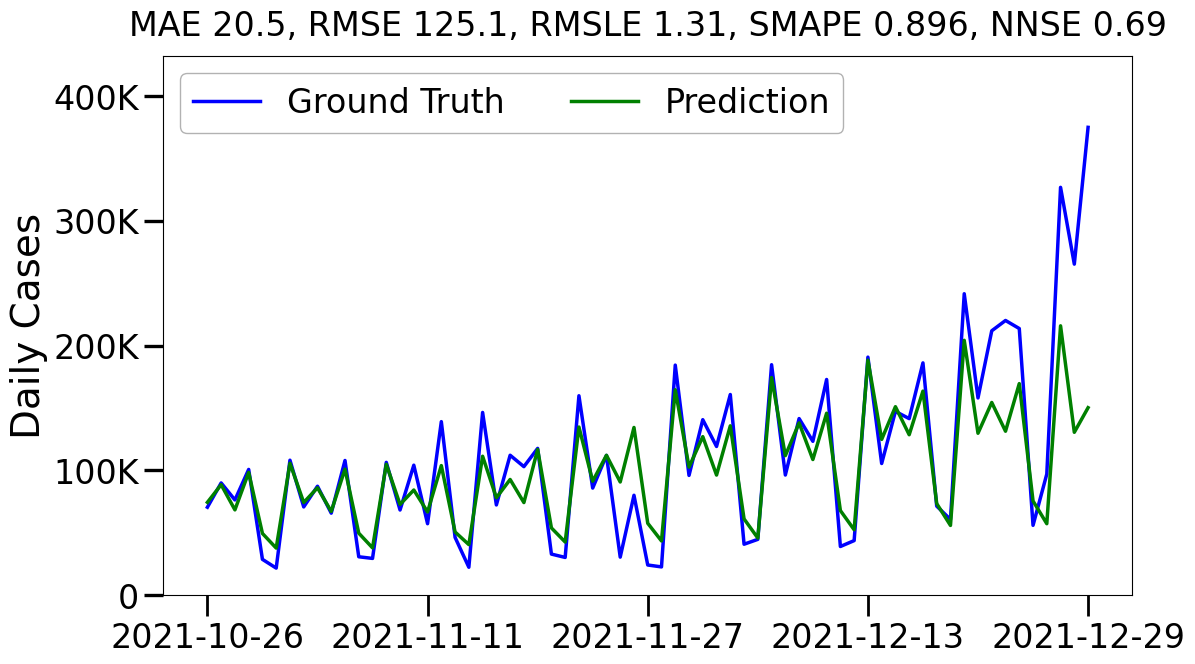

3248

In [40]:
print(f'\n---Test results--\n')
test_raw_predictions, test_index = tft.predict(
    test_dataloader, mode="raw", return_index=True, 
    show_progress_bar=args.show_progress_bar
)
test_predictions = upscale_prediction(
    targets, test_raw_predictions['prediction'], 
    target_scaler, max_prediction_length
)

test_result_merged = processor.align_result_with_dataset(
    test_data, test_predictions, test_index
)
show_result(test_result_merged, targets)
plotter.summed_plot(test_result_merged, 'Test', save=False)
gc.collect()

## Attention weights

In [41]:
plotWeights = PlotWeights(
    args.figPath, max_encoder_length, 
    tft, show=args.show_progress_bar
)

## Interpret

In [64]:
attention_mean, attention = processor.get_mean_attention(
    tft.interpret_output(test_raw_predictions), 
    test_index, return_attention=True
)

gc.collect()

0

In [65]:
attention.dtypes

0              float32
1              float32
2              float32
3              float32
4              float32
5              float32
6              float32
7              float32
8              float32
9              float32
10             float32
11             float32
12             float32
Date    datetime64[ns]
FIPS            object
dtype: object

In [66]:
df = pd.read_csv('../results/TFT_baseline/figures/attention.csv')
df['Date'] = to_datetime(df['Date'])
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Date,FIPS
0,0.005,0.022,0.177,0.004,0.008,0.038,0.490,0.093,0.067,0.069,0.003,0.007,0.018,2020-03-13,10001
1,0.129,0.001,0.010,0.057,0.023,0.101,0.336,0.089,0.001,0.009,0.062,0.026,0.155,2020-03-14,10001
2,0.091,0.018,0.003,0.006,0.150,0.064,0.395,0.041,0.008,0.002,0.004,0.131,0.088,2020-03-15,10001


In [71]:
max_encoder_length = 13
encoder_indices = list(range(max_encoder_length))
df.rename(
    {str(index):index for index in encoder_indices}, 
    axis=1, inplace=True
)

In [74]:
attention = attention[attention['Date']>df['Date'].max()]
attention = pd.concat([df, attention], axis=0)

In [75]:
attention.round(4).to_csv(
    os.path.join(plotWeights.figPath, 'attention.csv')
    , index=False
)

# End

In [43]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2023-03-14 19:45:27.140850. Elapsed time 0:01:30.882483
